HW6 

Supervised Monte Carlo iterations = 1, mock example case


Based on the C-Range selected in the previous portion, we will now use that range to perform a single Monte-Carlo Iteration

Doing this just a single time helps us with a few things :

Repeating can be done easily by just adding an external loop
We can get an overall sense, idea of the code workings over just a single Monte-Carlo Iteration
Various one time results can be obtained in this test case with the Monte-Carlo iteration case focusing more on the 'cumulative' performance scores

C Range is 10^-1 to 10^7

In [34]:
import pandas as pd
import numpy as np

df = pd.read_csv('wdbc.csv', header = None)


output = df.iloc[:,0]


for i in np.arange(0,df.shape[0]):
    if output.iloc[i] == 'B':
        output.iloc[i] = 0
    else:
        output.iloc[i] = 1



features = df.iloc[:,1:]


from sklearn.preprocessing import normalize

features_normal = normalize(features)


features_normal_df = pd.DataFrame(features_normal)


norm_whole = pd.concat([features_normal_df,output],axis=1)


col_head = norm_whole.columns


norm_whole.columns= ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23','X24','X25','X26','X27','X28','X29','X30','y']


norm_whole.sort_values(by=['y'],inplace=True)


norm_whole.reset_index(drop=True,inplace=True)


X_y_0 = norm_whole.iloc[0:357,:]
X_y_1 = norm_whole.iloc[357:569,:]
X_y_1.reset_index(drop=True,inplace=True)


from sklearn.model_selection import train_test_split

X_y_train_0,X_y_test_0 = train_test_split(X_y_0,test_size = 0.2,shuffle=True)
X_y_train_1,X_y_test_1 = train_test_split(X_y_1,test_size = 0.2,shuffle=True)



X_y_train = pd.concat([X_y_train_0,X_y_train_1],axis=0)
X_y_test = pd.concat([X_y_test_0,X_y_test_1],axis=0)


from sklearn.utils import shuffle

X_y_train = shuffle(X_y_train)
X_y_test = shuffle(X_y_test)



X_y_train.reset_index(drop=True,inplace=True)
X_y_test.reset_index(drop=True,inplace=True)


X_train = X_y_train.drop(columns=['y'])
X_test = X_y_test.drop(columns=['y'])
y_train = X_y_train['y'].astype(int)
y_test =  X_y_test['y'].astype(int)
print(X_train)
print(y_train)
print(X_test)
print(y_test)


           X1        X2        X3        X4        X5        X6        X7  \
0    0.007675  0.007111  0.051206  0.475626  0.000044  0.000065  0.000098   
1    0.017425  0.023832  0.110188  0.669121  0.000106  0.000048  0.000019   
2    0.010449  0.014722  0.069250  0.552095  0.000073  0.000092  0.000148   
3    0.019843  0.038944  0.126141  0.590068  0.000219  0.000170  0.000018   
4    0.012577  0.011691  0.084037  0.577521  0.000088  0.000175  0.000170   
..        ...       ...       ...       ...       ...       ...       ...   
449  0.021543  0.041537  0.136327  0.577915  0.000256  0.000183  0.000000   
450  0.011022  0.013085  0.072670  0.661867  0.000057  0.000074  0.000105   
451  0.017363  0.019220  0.111276  0.617599  0.000134  0.000113  0.000063   
452  0.016406  0.023998  0.104639  0.600502  0.000126  0.000087  0.000040   
453  0.014179  0.019271  0.091652  0.649252  0.000091  0.000080  0.000065   

           X8        X9       X10  ...       X21       X22       X23  \
0  

As discussed previously, this section of the code has now generated X_train,X_test,y_train,y_test with the following deliberations :

They are normalized, feature wise (whole set, ONCE, initially)
They are randomly selected from the normalized set
The test has 20 % of both the positive and negative classes
After combining positive and negative classes, selected randomly, for train and test, from positive and negative class subsets of the original dataset, in the consequential proportions, we've shuffled them once more so that positive classes don't appear in a continuous arrangement after the negative classes (or vice versa), and thus positive and negative classes in train and test both, appear randomly, but still contain the classes in a required proportion as mentioned.

Thus they have the needed positive and negative class proportion in test, are randomly selected, and have normalized features.

Further explanation of this code section given previously

Selecting final penalty parameter using 5-fold CV

In [35]:
from sklearn.model_selection import KFold  # Stratified KFold may be used. Class imbalance doesn't seem severe, at least from the outset, currently, and thus simple KFold has been used. As such using Stratified KFold only minorly modifies the code
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")   # For a few values of C, over a few folds, convergence didn't occur and output window was flooded with warnings, to avoid this we've used this code

kf = KFold(n_splits=5,shuffle=True)

C = np.array([10**(-1),10**(0),10**(1),10**(2),10**(3),10**(4),10**(5),10**(6),10**(7)])  # Selected a priori

# For a given C, all 5 folds will be run at a time. Thus different C's may have different folds (mostly should), but due to
# 'averaging' this shouldn't affect comparative results

error_df = pd.DataFrame(index = C, columns = ['Estimated Test Errors'])

for i in np.arange(0,C.size):
    
    cv_ite = -1
    cv_error_vector = np.zeros(5)   # Corresponding to CV iterations
    
    for train,test in kf.split(X_train):
        
        cv_ite = cv_ite + 1  # CV iteration count (0,1,2,3,4 for 1,2,3,4,5 fold iterations)
        X_train_cv,X_test_cv = X_train.iloc[train,:],X_train.iloc[test,:]
        y_train_cv,y_test_cv = y_train[train],y_train[test]
        clf = LinearSVC(penalty='l1',dual=False,C=C[i]).fit(X_train_cv,y_train_cv)
        y_test_cv_pred = clf.predict(X_test_cv)
        
        mis = 0
        for l in np.arange(0,X_test_cv.shape[0]):
            if y_test_cv_pred[l] != y_test_cv.iloc[l]:
                mis = mis + 1
        
        percent_error = (mis/X_test_cv.shape[0])*100
        cv_error_vector[cv_ite] = percent_error
        
    
    error_df.iloc[i,0] = np.mean(cv_error_vector)


print(error_df)

           Estimated Test Errors
0.1                      21.3773
1.0                       7.9243
10.0                     7.48962
100.0                    5.50183
1000.0                   4.84737
10000.0                  3.74847
100000.0                  4.8547
1000000.0                4.40781
10000000.0               5.73382


Selecting C which gives minimum test error estimate 
(Note : 10,000 was the most frequent over a few runs. In Monte-Carlo, we can pick a measure of central tendency over all the runs, here we'll automatically select the C which gives minimum error. In Monte-Carlo also we do the same, only difference being we record which C is selected for each Monte-Carlo iteration, then pick an 'averaged C' using a measure of central tendency (mode may be used here))

In [36]:
min_error = np.min(error_df.to_numpy().flatten())
min_C = C[np.argmin(error_df.to_numpy().flatten())]

print('The minimum test error estimate obtained is thus : \n',min_error,'%')
print('The C for which this minimum test error is obtained is thus : \n',min_C)

The minimum test error estimate obtained is thus : 
 3.7484737484737485 %
The C for which this minimum test error is obtained is thus : 
 10000.0


Using min_C, X_train, X_test, y_train, y_test for various scores (as asked in the question)

(These scores, will be then averaged over all Monte-Carlo iterations, once it is performed in the next part)

Actual Test Error

In [37]:
clf_final = LinearSVC(penalty='l1',dual=False,C=min_C).fit(X_train,y_train)
y_test_pred = clf_final.predict(X_test)

mis = 0
for l in np.arange(0,X_test.shape[0]):
    if y_test_pred[l] != y_test.iloc[l]:
        mis = mis + 1

test_error = (mis/X_test.shape[0])*100
print('The actual test error, for minimizing C is obtained : \n',test_error,'%')

The actual test error, for minimizing C is obtained : 
 4.3478260869565215 %


Accuracy, Precision, Recall, F1 Score (Training)

In [38]:
y_train_pred = clf_final.predict(X_train)

mis = 0
for l in np.arange(0,X_train.shape[0]):
    if y_train_pred[l] != y_train.iloc[l]:
        mis = mis + 1

train_error = (mis/X_train.shape[0])*100
print('The training error, for minimizing C is obtained : \n',train_error,'%')


The training error, for minimizing C is obtained : 
 1.9823788546255507 %


In [39]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_train,y_train_pred)

print('The confusion matrix for training is : \n',confusion_matrix_train)

The confusion matrix for training is : 
 [[282   3]
 [  6 163]]


In [42]:
confusion_matrix_train_df = pd.DataFrame(confusion_matrix_train,index=['Actually 0','Actually 1'],columns=['Predicted 0','Predicted 1'])
print('The confusion matrix for train, appropriately indexed is : \n',confusion_matrix_train_df)

The confusion matrix for train, appropriately indexed is : 
             Predicted 0  Predicted 1
Actually 0          282            3
Actually 1            6          163


In [43]:
precision_train = (confusion_matrix_train[1][1]/(confusion_matrix_train[1][1]+confusion_matrix_train[0][1]))*100
recall_train = (confusion_matrix_train[1][1]/(confusion_matrix_train[1][1]+confusion_matrix_train[1][0]))*100

print('The precision for train is : \n',precision_train,'%')
print('The recall for train is : \n',recall_train,'%')

The precision for train is : 
 98.19277108433735 %
The recall for train is : 
 96.44970414201184 %


In [45]:
accuracy_train = ((confusion_matrix_train[0][0]+confusion_matrix_train[1][1])/(confusion_matrix_train[0][0]+confusion_matrix_train[1][1]+confusion_matrix_train[0][1]+confusion_matrix_train[1][0]))*100
f1_train = ((2*(precision_train/100)*(recall_train/100))/((precision_train/100)+(recall_train/100))) # divided by 100 as precision and recall specified in percentage
print('The accuracy for training is : \n',accuracy_train,'%')
print('The f1 score for training is : \n',f1_train)

The accuracy for training is : 
 98.01762114537445 %
The f1 score for training is : 
 0.973134328358209


Accuracy, Precision, Recall, F1 Score (Test)

In [46]:
confusion_matrix_test = confusion_matrix(y_test,y_test_pred)

print('The confusion matrix for test is : \n',confusion_matrix_test)

The confusion matrix for test is : 
 [[68  4]
 [ 1 42]]


In [47]:
confusion_matrix_test_df = pd.DataFrame(confusion_matrix_test,index=['Actually 0','Actually 1'],columns=['Predicted 0','Predicted 1'])
print('The confusion matrix for test, appropriately indexed is : \n',confusion_matrix_test_df)

The confusion matrix for test, appropriately indexed is : 
             Predicted 0  Predicted 1
Actually 0           68            4
Actually 1            1           42


In [48]:
precision_test = (confusion_matrix_test[1][1]/(confusion_matrix_test[1][1]+confusion_matrix_test[0][1]))*100
recall_test = (confusion_matrix_test[1][1]/(confusion_matrix_test[1][1]+confusion_matrix_test[1][0]))*100

print('The precision for test is : \n',precision_test,'%')
print('The recall for test is : \n',recall_test,'%')

The precision for test is : 
 91.30434782608695 %
The recall for test is : 
 97.67441860465115 %


In [49]:
accuracy_test = ((confusion_matrix_test[0][0]+confusion_matrix_test[1][1])/(confusion_matrix_test[0][0]+confusion_matrix_test[1][1]+confusion_matrix_test[0][1]+confusion_matrix_test[1][0]))*100
f1_test = ((2*(precision_test/100)*(recall_test/100))/((precision_test/100)+(recall_test/100))) # divided by 100 as precision and recall specified in percentage
print('The accuracy for test is : \n',accuracy_test,'%')
print('The f1 score for test is : \n',f1_test)

The accuracy for test is : 
 95.65217391304348 %
The f1 score for test is : 
 0.9438202247191011


ROC and AUC for Train

NOTE : Probabilities are not available in LinearSVC, SVC does have Probabilities but does not have L1 Penalization
Thus we will use CalibrateClassifierCV in sklearn to obtain probabilities using the decision_function of our clf_final (final optimized classifier)

In [50]:
from sklearn.calibration import CalibratedClassifierCV

clf_prob = LinearSVC(penalty='l1',dual=False,C=min_C)
calibrated_svc = CalibratedClassifierCV(clf_prob,method='sigmoid') # probabilities estimated via sigmoid method
calibrated_svc.fit(X_train,y_train)
y_train_pred_prob = calibrated_svc.predict_proba(X_train)

print(y_train_pred_prob)

# References for this code https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py
# References for this code https://stackoverflow.com/questions/35212213/sklearn-how-to-get-decision-probabilities-for-linearsvc-classifier

[[2.19475125e-03 9.97805249e-01]
 [9.96826196e-01 3.17380404e-03]
 [7.80424122e-03 9.92195759e-01]
 [9.89412847e-01 1.05871532e-02]
 [8.43557597e-02 9.15644240e-01]
 [8.46308841e-01 1.53691159e-01]
 [3.69495632e-02 9.63050437e-01]
 [8.81198933e-01 1.18801067e-01]
 [9.99851943e-01 1.48057257e-04]
 [9.14301381e-01 8.56986187e-02]
 [9.31603811e-01 6.83961886e-02]
 [7.82525170e-02 9.21747483e-01]
 [9.57557807e-01 4.24421925e-02]
 [2.56678517e-03 9.97433215e-01]
 [9.97595407e-01 2.40459336e-03]
 [1.42115858e-01 8.57884142e-01]
 [4.13021243e-01 5.86978757e-01]
 [9.92222555e-01 7.77744481e-03]
 [9.96431491e-01 3.56850850e-03]
 [9.99442051e-01 5.57949419e-04]
 [4.38086757e-02 9.56191324e-01]
 [9.87022455e-01 1.29775450e-02]
 [9.99972218e-01 2.77822598e-05]
 [8.15784125e-01 1.84215875e-01]
 [9.99319710e-01 6.80290045e-04]
 [1.28885698e-03 9.98711143e-01]
 [6.59915994e-02 9.34008401e-01]
 [6.73612584e-01 3.26387416e-01]
 [1.06811521e-01 8.93188479e-01]
 [9.19346122e-01 8.06538781e-02]
 [4.181826

Column 1 : Probability of classifying to 0
Column 2 : Probability of classifying to 1

These probabilities will be used for the ROC curves and for AUC

In [56]:
y_train_pred_prob_0 = y_train_pred_prob[:,0]
print(y_train_pred_prob_0)

[2.19475125e-03 9.96826196e-01 7.80424122e-03 9.89412847e-01
 8.43557597e-02 8.46308841e-01 3.69495632e-02 8.81198933e-01
 9.99851943e-01 9.14301381e-01 9.31603811e-01 7.82525170e-02
 9.57557807e-01 2.56678517e-03 9.97595407e-01 1.42115858e-01
 4.13021243e-01 9.92222555e-01 9.96431491e-01 9.99442051e-01
 4.38086757e-02 9.87022455e-01 9.99972218e-01 8.15784125e-01
 9.99319710e-01 1.28885698e-03 6.59915994e-02 6.73612584e-01
 1.06811521e-01 9.19346122e-01 4.18182684e-02 9.77028241e-01
 3.23063968e-01 9.98831744e-01 9.94833794e-01 2.06578884e-02
 7.84407789e-01 9.58108140e-01 7.60074122e-02 1.75842318e-01
 6.75073575e-01 7.84595233e-01 9.76316974e-01 7.31078201e-01
 2.56082590e-03 2.99786402e-02 9.80299001e-01 9.43289139e-02
 8.89823752e-01 7.17023028e-02 9.99872598e-01 9.88187117e-01
 8.58042014e-01 5.45141001e-03 9.93554548e-01 6.37051314e-02
 1.69022441e-01 9.98770964e-01 9.98441665e-01 3.50993454e-02
 8.20711988e-01 9.84940339e-01 5.33998359e-01 5.15147922e-01
 9.40950299e-01 1.097126

In [60]:
thresh = np.arange(0,1.01,0.01)
ROC_df = pd.DataFrame(index=thresh,columns=['FPR','TPR'])
for i in np.arange(0,thresh.size):
    y_train_pred_roc = (y_train_pred_prob_0 <= thresh[i]).astype(int)
    confusion_matrix_train_roc = confusion_matrix(y_train,y_train_pred_roc)
    ROC_df.iloc[i,0] = confusion_matrix_train_roc[0][1]/(confusion_matrix_train_roc[0][1]+confusion_matrix_train_roc[0][0])
    ROC_df.iloc[i,1] = confusion_matrix_train_roc[1][1]/(confusion_matrix_train_roc[1][1]+confusion_matrix_train_roc[1][0])
print(ROC_df)

           FPR       TPR
0.00         0         0
0.01         0  0.224852
0.02         0  0.325444
0.03         0  0.431953
0.04         0  0.497041
...        ...       ...
0.96  0.396491         1
0.97  0.442105         1
0.98  0.526316         1
0.99  0.645614         1
1.00         1         1

[101 rows x 2 columns]


Text(0, 0.5, 'TPR for Train')

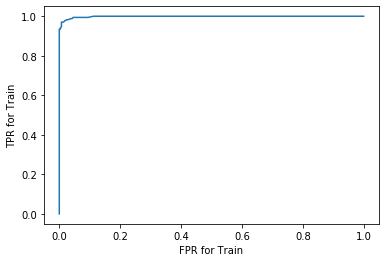

In [62]:
import matplotlib.pyplot as plt

plt.plot(ROC_df['FPR'],ROC_df['TPR'])
plt.xlabel('FPR for Train')
plt.ylabel('TPR for Train')

ROC for Train, as seen above

In [63]:
from sklearn import metrics
AUC_train = metrics.auc(ROC_df['FPR'],ROC_df['TPR'])
print('The AUC for train is : \n',AUC_train)

The AUC for train is : 
 0.9984947576040694


In [64]:
y_test_pred_prob = calibrated_svc.predict_proba(X_test)
y_test_pred_prob_0 = y_test_pred_prob[:,0]
print(y_test_pred_prob_0)

[9.87914112e-01 2.95722008e-02 5.40660964e-02 1.82514763e-01
 6.77556212e-01 5.30794873e-01 9.99999297e-01 9.99932542e-01
 3.06842063e-02 7.23908449e-01 9.57465035e-01 9.60202803e-03
 9.90411941e-01 1.67174952e-03 9.99999893e-01 9.99395496e-01
 9.74482553e-01 1.00281658e-02 9.78412960e-01 6.31515358e-03
 9.99069495e-01 5.11584790e-02 9.69048363e-01 4.52281024e-02
 6.81397309e-03 9.74661710e-01 8.57151161e-01 7.87259470e-01
 1.05601688e-01 9.89489815e-01 4.74812300e-01 1.77456860e-02
 9.27428554e-01 1.93651137e-02 5.02643641e-01 2.56514912e-01
 9.88497588e-01 3.74933119e-03 1.23594285e-01 9.99052251e-01
 7.15733448e-01 9.97020266e-01 9.96167658e-01 5.87513758e-02
 8.94047288e-01 9.95332539e-01 3.55057533e-01 2.73701837e-03
 2.39462829e-03 6.24080726e-03 9.79086993e-01 9.61694387e-01
 1.88943831e-02 8.90994004e-01 9.19716752e-01 9.36639993e-01
 4.97225919e-01 9.99186867e-01 9.59179684e-01 9.77644740e-01
 9.51978880e-01 6.82927727e-01 8.52111668e-01 2.04232921e-03
 9.93555941e-01 9.956131

In [65]:
thresh = np.arange(0,1.01,0.01)
ROC_df_test = pd.DataFrame(index=thresh,columns=['FPR','TPR'])
for i in np.arange(0,thresh.size):
    y_test_pred_roc = (y_test_pred_prob_0 <= thresh[i]).astype(int)
    confusion_matrix_test_roc = confusion_matrix(y_test,y_test_pred_roc)
    ROC_df_test.iloc[i,0] = confusion_matrix_test_roc[0][1]/(confusion_matrix_test_roc[0][1]+confusion_matrix_test_roc[0][0])
    ROC_df_test.iloc[i,1] = confusion_matrix_test_roc[1][1]/(confusion_matrix_test_roc[1][1]+confusion_matrix_test_roc[1][0])
print(ROC_df_test)

           FPR       TPR
0.00         0         0
0.01         0  0.372093
0.02         0  0.488372
0.03         0  0.534884
0.04         0  0.604651
...        ...       ...
0.96  0.388889         1
0.97  0.458333         1
0.98  0.583333         1
0.99  0.694444         1
1.00         1         1

[101 rows x 2 columns]


Text(0, 0.5, 'TPR for Test')

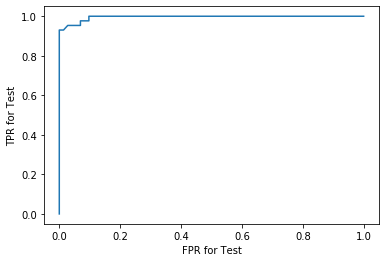

In [66]:
plt.plot(ROC_df_test['FPR'],ROC_df_test['TPR'])
plt.xlabel('FPR for Test')
plt.ylabel('TPR for Test')

In [67]:
AUC_test = metrics.auc(ROC_df_test['FPR'],ROC_df_test['TPR'])
print('The AUC for test is : \n',AUC_test)

The AUC for test is : 
 0.9956395348837209


The above are ROC curves for test and AUC for test

All these values and curves have been shown for one Random Monte-Carlo iteration

So for the actual M=30 Monte-Carlo iterations, we will not show the curves and confusion matrices for train and test for a random Monte-Carlo trial, as they have already been shown here for some random Monte-Carlo trial